In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [ ]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
sym = 'NQ'
start_date='20180901'
end_date='20191231'
periods=[5,10,20,40,80,160]
s='20180501'
params = {
    'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s),
    'ema': calibrate_multiple(sym, ema, start_date=s),
    'breakout': calibrate_multiple(sym, breakout, start_date=s),
    'carver': calibrate_multiple(sym, carver, start_date=s),
    'roc': calibrate_multiple(sym, roc, start_date=s)
}
params_s = {}
inds_s = {}
for i in [bolli_reduced, ema, breakout, carver, roc]:
    tup = run(sym, i, start_date=start_date, end_date=end_date, periods=periods, save_params=True)
    params_s[i.__name__] = tup[1]
    inds_s[i.__name__] = tup[0]
"""
inds_s = {
        'bolli_reduced': run(sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
        #'ema': run(sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
        'breakout': run(sym, breakout, start_date=start_date, end_date=end_date, periods=periods),
        'carver': run(sym, carver, start_date=start_date, end_date=end_date, periods=periods),
        'roc': run(sym, roc, start_date=start_date, end_date=end_date, periods=periods)
}
"""
start_date = '20190101'
inds_c = {
    'bolli_reduced': simulate(params['bolli_reduced'], sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=periods),
    'carver': simulate(params['carver'], sym, carver, start_date=start_date, end_date=end_date, periods=periods),
    'roc': simulate(params['roc'], sym, roc, start_date=start_date, end_date=end_date, periods=periods)
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}


In [10]:
inds = inds_c

In [11]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
bolli_reduced,9.88204,6.28866
ema,9.84798,5.8497
breakout,9.24281,6.4064
carver,7.26454,4.79831
roc,9.06729,5.83009


In [12]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,bolli_reduced,ema,breakout,carver,roc
bolli_reduced,1.000000,0.807240,0.932117,0.938069,0.928332
ema,0.807240,1.000000,0.741332,0.820045,0.911282
breakout,0.932117,0.741332,1.000000,0.932154,0.883112
carver,0.938069,0.820045,0.932154,1.000000,0.938652
roc,0.928332,0.911282,0.883112,0.938652,1.000000


In [13]:
c.sum()

bolli_reduced    4.605758
ema              4.279899
breakout         4.488714
carver           4.628919
roc              4.661378
dtype: float64

In [14]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()})
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df.dropna()

In [15]:
data=combine(inds,)

In [16]:
data.forecast.abs().mean(), data.forecast.abs().std()

(8.63808647524813, 5.512439455367442)

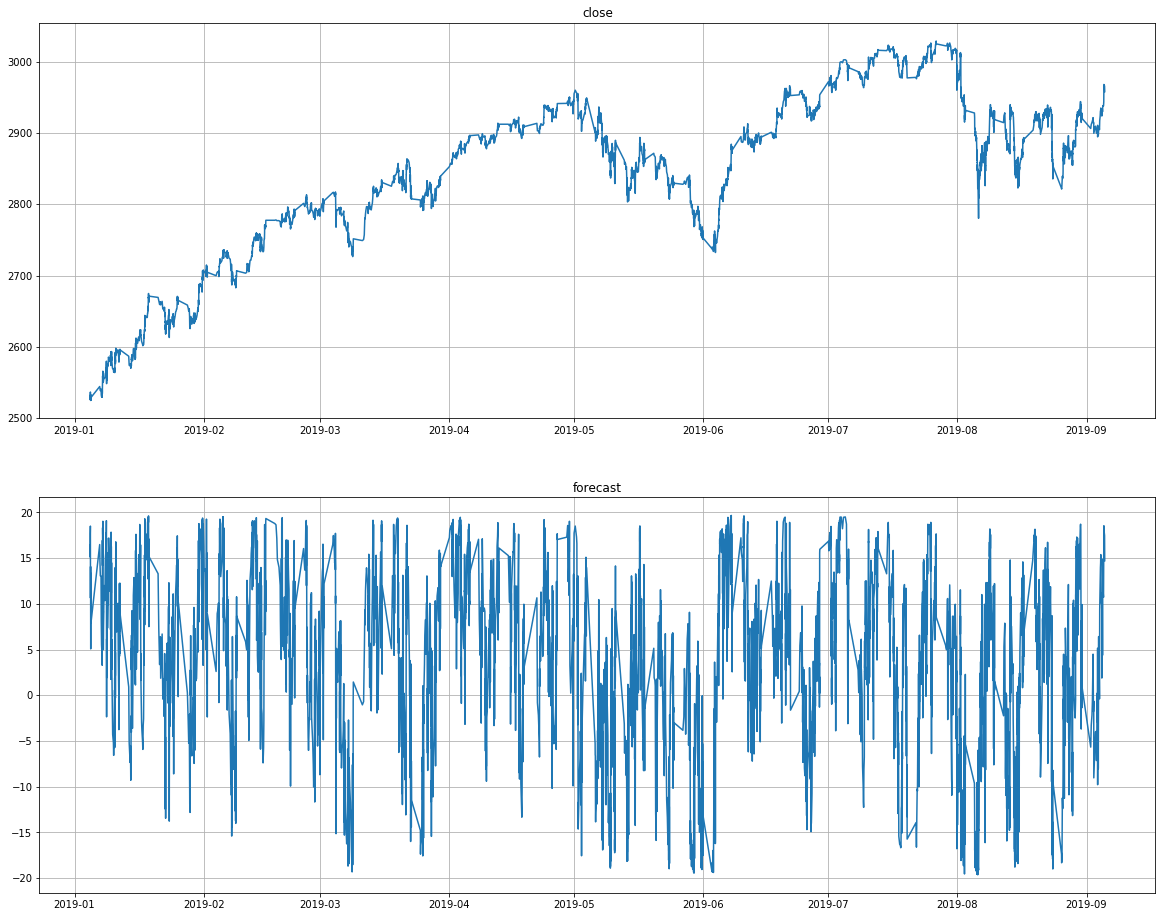

In [17]:
plot(data[['close', 'forecast']])

In [18]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.0140321,0.0919959,0.0703826,-0.000426447,0.00184857,-0.110237,-0.024643,-0.0852925,-0.032253
Cumulative returns,0.00977959,0.0633936,0.0486497,-0.000297855,0.00129071,-0.078336,-0.0172756,-0.0603654,-0.022637
Annual volatility,0.141698,0.124902,0.113077,0.11361,0.104396,0.090848,0.0519409,0.0322393,0.0175847
Sharpe ratio,0.168708,0.766701,0.657601,0.0524708,0.0693787,-1.24032,-0.454567,-2.74879,-1.85552
Calmar ratio,0.159439,1.54636,1.55893,-0.006504,0.0313241,-1.09552,-0.461511,-1.37012,-1.42479
Stability,0.121277,0.115874,0.58168,0.0340023,5.21757e-06,0.614773,0.28703,0.869387,0.838776
Max drawdown,-0.0880092,-0.0594919,-0.0451481,-0.0655669,-0.0590144,-0.100625,-0.0533963,-0.0622518,-0.022637
Omega ratio,1.02901,1.13914,1.12254,1.0091,1.012,0.79834,0.906409,0.496881,0.469055
Sortino ratio,0.241288,1.15646,1.03287,0.0823165,0.110378,-1.81865,-0.666013,-3.50894,-2.33017
Skew,0.206989,0.342977,0.724589,0.986286,0.967243,0.858758,0.540973,0.817302,-0.317039


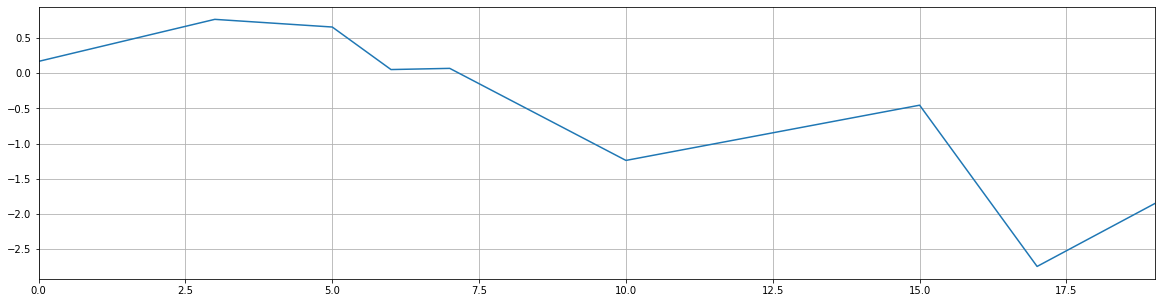

In [19]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [20]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.879608,0.803002,0.764528,0.719050,0.595456,0.239430,0.155395,-0.038516
3,0.879608,1.000000,0.917048,0.844203,0.801450,0.638550,0.289636,0.180991,0.001419
5,0.803002,0.917048,1.000000,0.948980,0.912012,0.716856,0.356657,0.203419,0.010078
6,0.764528,0.844203,0.948980,1.000000,0.950793,0.760095,0.391148,0.160016,0.016075
7,0.719050,0.801450,0.912012,0.950793,1.000000,0.806457,0.457973,0.216893,0.013264
10,0.595456,0.638550,0.716856,0.760095,0.806457,1.000000,0.580789,0.273307,-0.026368
15,0.239430,0.289636,0.356657,0.391148,0.457973,0.580789,1.000000,0.596964,-0.043890
17,0.155395,0.180991,0.203419,0.160016,0.216893,0.273307,0.596964,1.000000,0.068642
19,-0.038516,0.001419,0.010078,0.016075,0.013264,-0.026368,-0.043890,0.068642,1.000000


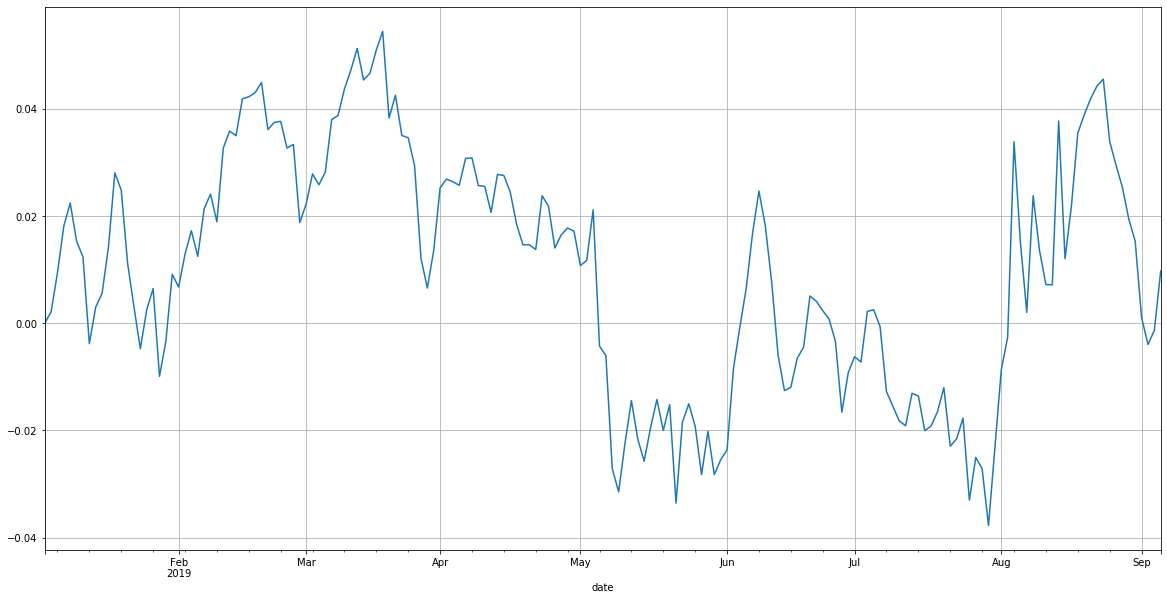

In [21]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

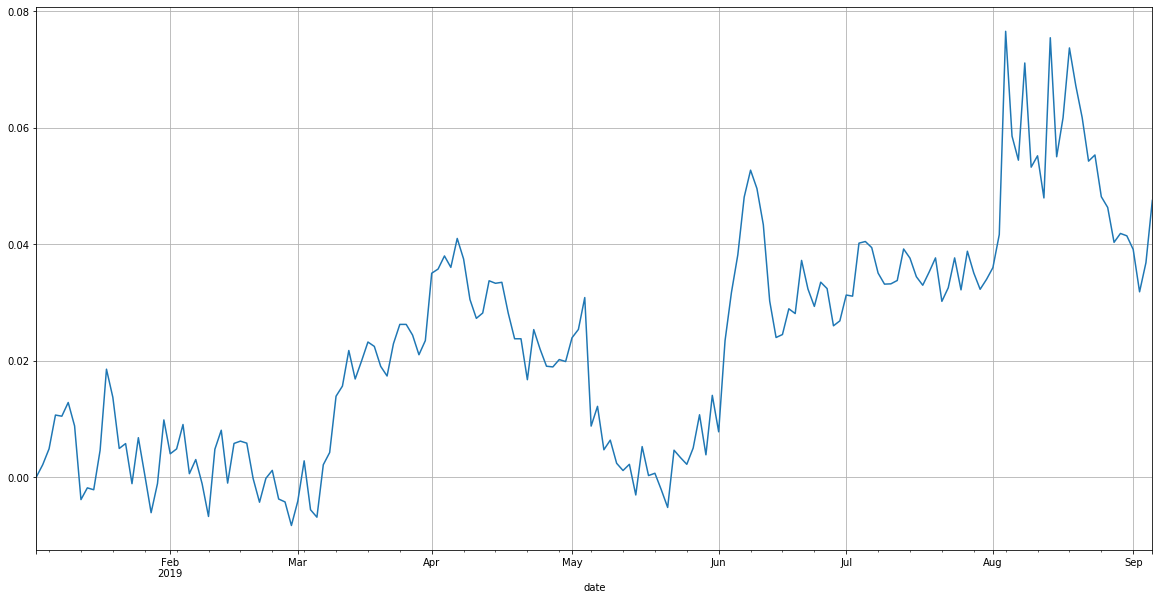

In [22]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

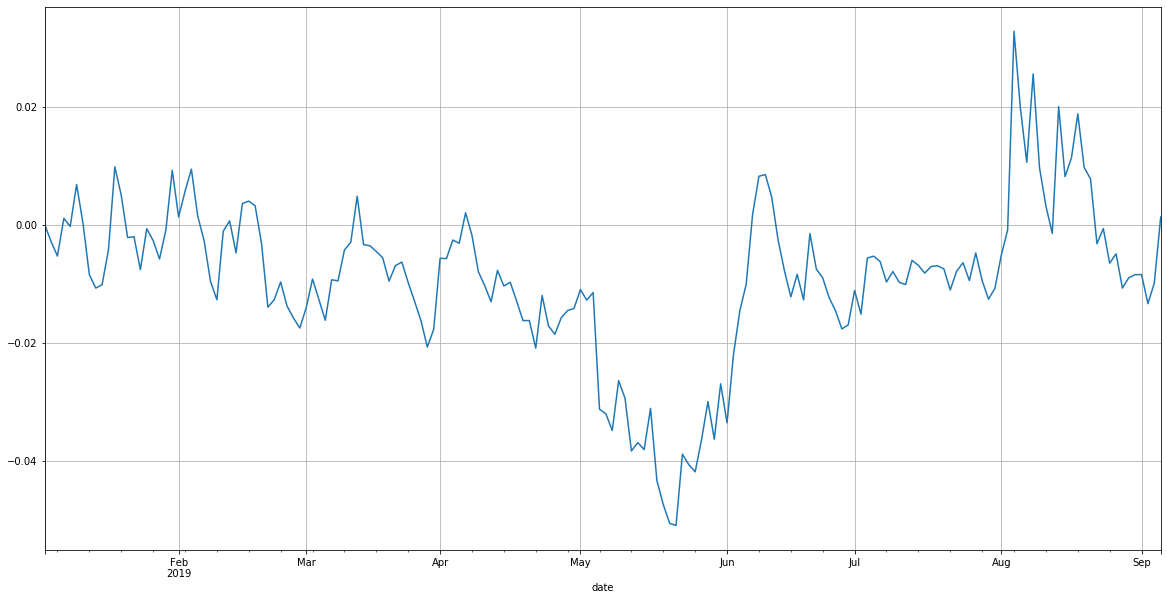

In [23]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

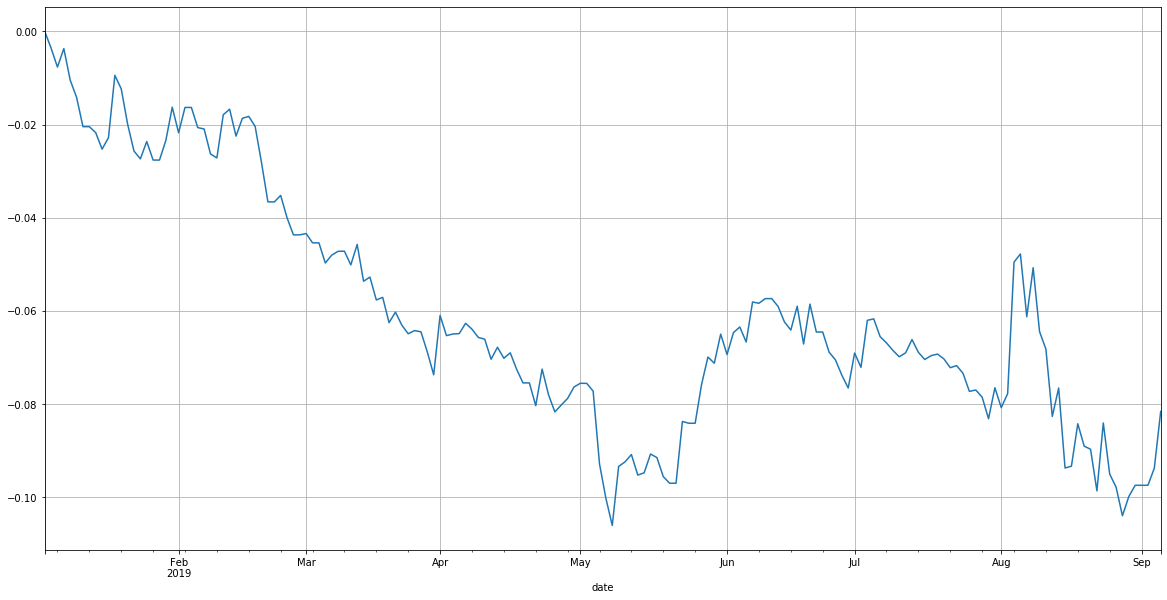

In [24]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);